In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torch.autograd import Variable
from torchvision import datasets, models, transforms
import os
import numpy as np

In [17]:
# Reference : Transfer learning tutorial from pytorch

# Data augmentation and normalization for training
# Just normalization for validation
#class torchvision.transforms.RandomResizedCrop(size, scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=2) (bi-linear interpolation)
#transforms.RandomResizedCrop(224) --> A crop of random size (default: of 0.08 to 1.0) of the original size and a 
#random aspect ratio (default: of 3/4 to 4/3) of the original aspect ratio is made. 
#This crop is finally resized to given size (224 in this case). 
#transforms.CenterCrop(224)--> Crops the image at the center. 224 is the Desired output size of the crop.
#class torchvision.transforms.Normalize(mean, std)
#Normalize a tensor image with mean and standard deviation. Given mean: (M1,...,Mn) and std: (S1,..,Sn) for n channels, 
#this transform will normalize each channel of the input torch.Tensor i.e. 
#input[channel] = (input[channel] - mean[channel]) / std[channel]
#Parameters:     mean (sequence) – Sequence of means for each channel.
#                std (sequence) – Sequence of standard deviations for each channel.

# Note: These transforms are applied sequentially in the order of appearance in list given to compose. 
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224), # ResNet that we plan to use expects all the imgs to be 224x224
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [18]:
data_dir = 'hymenoptera_data'

# Automatically retrieves the label from the folder name.
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}

data_loaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True) for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

print(f"Class names: {class_names}")
print(f"There are {len(data_loaders['train'])} batches from train set.")
print(f"There are {len(data_loaders['val'])} batches from val set.")
print(f"There are {len(image_datasets['train'])} images from train set.")
print(f"There are {len(image_datasets['val'])} images from val set.")

Class names: ['ants', 'bees']
There are 61 batches from train set.
There are 39 batches from val set.
There are 244 images from train set.
There are 153 images from val set.


In [19]:
# If pretrained not True, trained weights are not loaded.
model_conv = torchvision.models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /nfs/site/home/abalusan/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 335MB/s]


In [20]:
# Freeze all layers in the network
for param in model_conv.parameters():
    param.requires_grad = False

In [21]:
# Replace the final FC layer of the pretrained n/w to classify only 2 classes.
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs,2)

In [23]:
# one iter to understand what happens during finetuning

iter = 0
correct = 0

# labels returned by the data loader are numeric
for inputs, labels in data_loaders['train']:
    if iter == 1:
        break
    
    print(f"First iter:")
    print(f"{inputs.shape = }")
    print(f"{labels.shape = }")
    print(f"{labels = }")
    output = model_conv(inputs)
    print(f"{output = }")
    print(f"{output.shape = }")
    _, predicted = torch.max(output, 1)
    print(f"{predicted = }")
    print(f"{predicted.shape = }")
    correct += (predicted == labels).sum()
    print(f"{correct = }")

    iter += 1


First iter:
inputs.shape = torch.Size([4, 3, 224, 224])
labels.shape = torch.Size([4])
labels = tensor([0, 0, 0, 1])
output = tensor([[ 0.5264, -0.0162],
        [-0.9293,  0.2327],
        [-0.2246, -0.2683],
        [ 0.1049,  0.2739]], grad_fn=<AddmmBackward0>)
output.shape = torch.Size([4, 2])
predicted = tensor([0, 1, 0, 1])
predicted.shape = torch.Size([4])
correct = tensor(3)


In [24]:
criterion = nn.CrossEntropyLoss()

# We only give the FC layer parameters to the optimizer as we are only finetuning the last layer.
optimizer = optim.SGD(model_conv.fc.parameters(), lr = 0.001, momentum=0.9)

# step_size: LR reduced after this number of epochs, gamma: reduction factor of the lr
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [26]:
# train the network
# Why don't we have to set model.train() during finetuning?
num_epochs = 25

for epoch in range(num_epochs):
    # Perform a step(epoch) of the lr scheduler. 
    exp_lr_scheduler.step()

    correct = 0
    for images, labels in data_loaders['train']:
        optimizer.zero_grad()
        outputs = model_conv(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum()

    train_acc = 100* correct/dataset_sizes['train']
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f} Train Accuracy: {train_acc}%")

Epoch 1/25, Loss: 0.0687 Train Accuracy: 78.68852233886719%
Epoch 2/25, Loss: 0.0177 Train Accuracy: 79.09835815429688%
Epoch 3/25, Loss: 0.1179 Train Accuracy: 81.14753723144531%
Epoch 4/25, Loss: 0.0638 Train Accuracy: 81.55738067626953%
Epoch 5/25, Loss: 0.0928 Train Accuracy: 87.29508209228516%
Epoch 6/25, Loss: 0.2500 Train Accuracy: 86.0655746459961%
Epoch 7/25, Loss: 0.0494 Train Accuracy: 80.32786560058594%
Epoch 8/25, Loss: 0.6894 Train Accuracy: 84.01639556884766%
Epoch 9/25, Loss: 0.0723 Train Accuracy: 85.24590301513672%
Epoch 10/25, Loss: 0.1653 Train Accuracy: 84.83606719970703%
Epoch 11/25, Loss: 0.1583 Train Accuracy: 81.14753723144531%
Epoch 12/25, Loss: 0.8198 Train Accuracy: 86.0655746459961%
Epoch 13/25, Loss: 0.1008 Train Accuracy: 83.60655975341797%
Epoch 14/25, Loss: 0.1095 Train Accuracy: 81.14753723144531%
Epoch 15/25, Loss: 0.0962 Train Accuracy: 84.83606719970703%
Epoch 16/25, Loss: 0.3808 Train Accuracy: 86.47541046142578%
Epoch 17/25, Loss: 1.1480 Train Acc

In [33]:
# Evaluate the finetuned model
model_conv.eval()

with torch.no_grad():
    correct = 0
    total = 0

    for (images, labels) in data_loaders['val']:
        output = model_conv(images)
        _, pred = torch.max(output.data, 1)
        correct += (pred == labels).sum().item()
        total += labels.size(0)
    
    print(f"{(correct * 100)/total}%")

93.4640522875817%


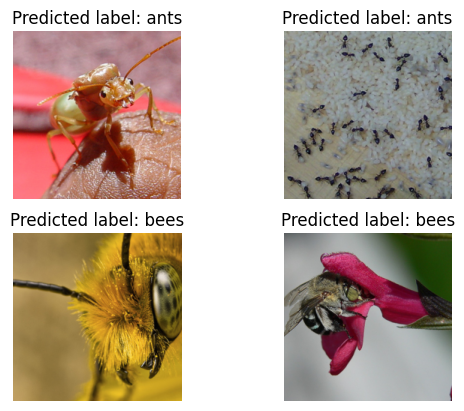

In [38]:
# Visualize predictions
import matplotlib.pyplot as plt

fig = plt.figure()
shown_batch = 0
index = 0

with torch.no_grad():
    for images, labels in data_loaders['val']:
        if shown_batch == 1:
            break

        shown_batch += 1
        output = model_conv(images)
        _, pred = torch.max(output.data, 1)

        for i in range(4):
            index += 1
            ax = plt.subplot(2,2,index)
            ax.axis('off')
            ax.set_title(f"Predicted label: {class_names[pred[i]]}")
            img = images.data[i]
            # Convert tensor to numpy array
            inp = img.numpy().transpose((1,2,0))              # If we have a tensor/NDArray of shape (2,3,4), the transpose changes it to (3,4,2) for correct visualization
            #inp = img.numpy()
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            # denormalizing the input image
            inp = std*inp + mean
            # Float data must be clipped to (0,1) for floats and (0,255) for ints for co correct display with imshow. 
            inp = np.clip(inp, 0, 1)
            plt.imshow(inp)
        